<a href="https://colab.research.google.com/github/antounes/cv/blob/main/02b_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers Image Classification Using a Neural Network

## Enable GPU and set up helper functions 

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found - On for CPU time!')
else:
  print('Found GPU at: {}'.format(device_name))

2.7.0
Found GPU at: /device:GPU:0


In [2]:
# Helper functions

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel('Epochs')
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_'+metric]);
    ax[idx].legend([metric, 'val_'+metric])

# Call model.predict() on a few images in the evaluation dataset

def plot_predicitons(filename):
  f, ax = plt.subplots(3, 5, figsize=(25, 15))
  dataset = tf.data.TextLineDataset(filename).map(decode_csv)
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow(img.numpy());
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES(label.numpy())
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15, 15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print('Scaling weights for {} in {} to {}'.format(flower_name, min_wt, max_wt))
    weights = (weights - min_wt) / (max_wt - min_wt)
    ax[flower].ishow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS));
    ax[flower].set_title(flower_name);

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode('utf8') 
for item in tf.strings.regex_replace(tf.io.gfile.glob('gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*'), 
                                     'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/', '')
]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find('.')==-1]
print('These are the available classes:', CLASS_NAMES)

# The label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ['path', 'flower']
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## A Neural Network Model

In [4]:
# Adding one non-linear layer in the middle

BATCH_SIZE = 32

train_dataset = tf.data.TextLineDataset(
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv'
).map(decode_csv).batch(BATCH_SIZE)

eval_dataset = tf.data.TextLineDataset(
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv'
).map(decode_csv).batch(BATCH_SIZE)

# Neural network with one hidden layer
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(units=128, activation='relu'),
          tf.keras.layers.Dense(units=len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 170s 2s/step - loss: 11.9777 - accuracy: 0.2345 - val_loss: 1.6090 - val_accuracy: 0.1811
Epoch 2/10
104/104 [==============================] - 134s 1s/step - loss: 1.6066 - accuracy: 0.2306 - val_loss: 1.6084 - val_accuracy: 0.2351
Epoch 3/10
104/104 [==============================] - 119s 1s/step - loss: 1.6040 - accuracy: 0.2458 - val_loss: 1.6078 - val_accuracy: 0.2351
Epoch 4/10
104/104 [==============================] - 111s 1s/step - loss: 1.6027 - accuracy: 0.2458 - val_loss: 1.6076 - val_accuracy: 0.2351
Epoch 5/10
104/104 [==============================] - 115s 1s/step - loss: 1.6011 - accuracy: 0.2458 - val_loss: 1.6080 - val_accuracy: 0.2351
Epoch 6/10
104/104 [==============================] - 109s 1s/step - loss: 1.5990 - accuracy: 0.2458 - val_loss: 1.6083 - val_accuracy: 0.2351
Epoch 7/10
104/104 [==============================] - 102s 977ms/step - loss: 1.5977 - accuracy: 0.2458 - val_loss: 1.6087 - val_accuracy: 0.

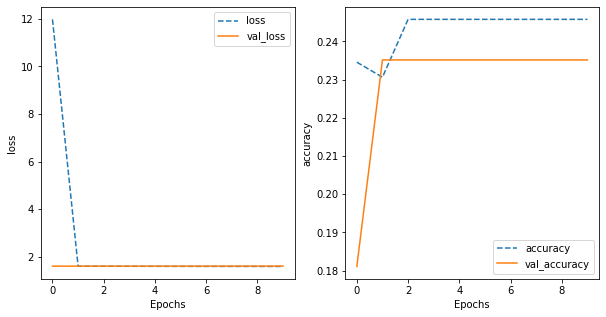

In [5]:
training_plot(['loss', 'accuracy'], history)

In [6]:
# parametrise to the values in the previous cell

def train_and_evaluate(batch_size=32,
                       lrate=0.001, # default learning rate in Adam constructor
                       l1=0,
                       l2=0,
                       num_hidden=128):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = tf.data.TextLineDataset(
      'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv'
  ).map(decode_csv).batch(batch_size)

  eval_dataset = tf.data.TextLineDataset(
      'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv'
  ).map(decode_csv).batch(batch_size)

  # Neural network with one hidden layer
  model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
            tf.keras.layers.Dense(units=num_hidden, kernel_regularizer=regularizer, activation='relu'),
            tf.keras.layers.Dense(units=len(CLASS_NAMES),
                                  kernel_regularizer=regularizer,
                                  activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  
  return model

Epoch 1/10
104/104 [==============================] - 115s 1s/step - loss: 2.1486 - accuracy: 0.3591 - val_loss: 1.6856 - val_accuracy: 0.4162
Epoch 2/10
104/104 [==============================] - 108s 1s/step - loss: 1.3862 - accuracy: 0.4403 - val_loss: 1.7755 - val_accuracy: 0.4189
Epoch 3/10
104/104 [==============================] - 99s 954ms/step - loss: 1.3808 - accuracy: 0.4573 - val_loss: 1.3310 - val_accuracy: 0.4703
Epoch 4/10
104/104 [==============================] - 107s 1s/step - loss: 1.2625 - accuracy: 0.4812 - val_loss: 1.2872 - val_accuracy: 0.4676
Epoch 5/10
104/104 [==============================] - 102s 985ms/step - loss: 1.2016 - accuracy: 0.5197 - val_loss: 1.3220 - val_accuracy: 0.4757
Epoch 6/10
104/104 [==============================] - 100s 956ms/step - loss: 1.1555 - accuracy: 0.5427 - val_loss: 1.2394 - val_accuracy: 0.4757
Epoch 7/10
104/104 [==============================] - 99s 952ms/step - loss: 1.1242 - accuracy: 0.5558 - val_loss: 1.2505 - val_accura

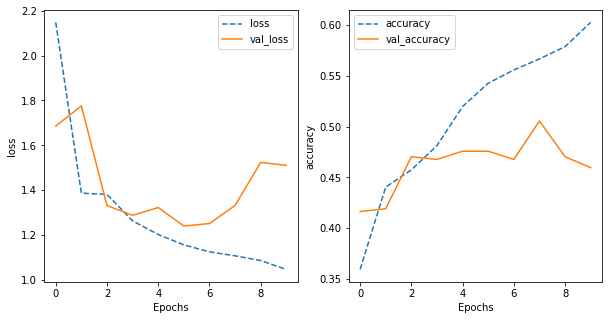

In [7]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

Epoch 1/10
104/104 [==============================] - 96s 915ms/step - loss: 2.6875 - accuracy: 0.3530 - val_loss: 1.5983 - val_accuracy: 0.4378
Epoch 2/10
104/104 [==============================] - 96s 926ms/step - loss: 1.5675 - accuracy: 0.4294 - val_loss: 1.6081 - val_accuracy: 0.4568
Epoch 3/10
104/104 [==============================] - 98s 945ms/step - loss: 1.4274 - accuracy: 0.4703 - val_loss: 1.5590 - val_accuracy: 0.4459
Epoch 4/10
104/104 [==============================] - 97s 932ms/step - loss: 1.3403 - accuracy: 0.5021 - val_loss: 1.6484 - val_accuracy: 0.4405
Epoch 5/10
104/104 [==============================] - 96s 924ms/step - loss: 1.2972 - accuracy: 0.5252 - val_loss: 1.6967 - val_accuracy: 0.4649
Epoch 6/10
104/104 [==============================] - 104s 996ms/step - loss: 1.2882 - accuracy: 0.5273 - val_loss: 1.8041 - val_accuracy: 0.4162
Epoch 7/10
104/104 [==============================] - 101s 966ms/step - loss: 1.2371 - accuracy: 0.5515 - val_loss: 1.7702 - val_

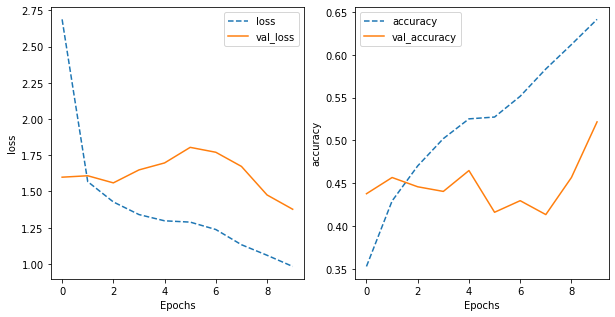

In [8]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

Epoch 1/10
104/104 [==============================] - 97s 924ms/step - loss: 2.5373 - accuracy: 0.3736 - val_loss: 1.4926 - val_accuracy: 0.4622
Epoch 2/10
104/104 [==============================] - 96s 920ms/step - loss: 1.6120 - accuracy: 0.4552 - val_loss: 1.5333 - val_accuracy: 0.4514
Epoch 3/10
104/104 [==============================] - 94s 898ms/step - loss: 1.4989 - accuracy: 0.4985 - val_loss: 1.5341 - val_accuracy: 0.4486
Epoch 4/10
104/104 [==============================] - 95s 910ms/step - loss: 1.3985 - accuracy: 0.5367 - val_loss: 1.5397 - val_accuracy: 0.4541
Epoch 5/10
104/104 [==============================] - 94s 906ms/step - loss: 1.3276 - accuracy: 0.5667 - val_loss: 1.5913 - val_accuracy: 0.4568
Epoch 6/10
104/104 [==============================] - 97s 929ms/step - loss: 1.2800 - accuracy: 0.5797 - val_loss: 1.7223 - val_accuracy: 0.4243
Epoch 7/10
104/104 [==============================] - 96s 924ms/step - loss: 1.2786 - accuracy: 0.5861 - val_loss: 1.8185 - val_ac

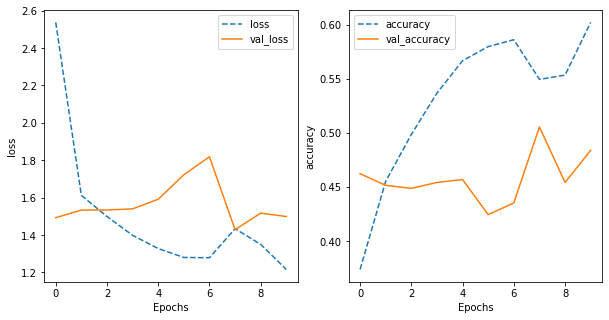

In [9]:
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=128)

## Hyperparameter tuning

In [10]:
!pip install --quiet keras-tuner

     |████████████████████████████████| 98 kB 2.8 MB/s 


In [ ]:
import kerastuner as kt

def build_model(hp):
  lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
  l1 = 0
  l2 = hp.Choice('l2', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])
  num_hidden = hp.Int('num_hidden', 32, 256, 32)
  
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  # Neural network with one hidden layer
  model = tf.keras.Sequential([
        tf.keras.layers.Flatten(
            input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]),
        tf.keras.layers.Dense(
            units=num_hidden,
            kernel_regularizer=regularizer,
            activation='relu'),
        tf.keras.layers.Dense(
            units=len(CLASS_NAMES), 
            kernel_regularizer=regularizer,
            activation='softmax')
                              
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rage=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  return model

batch_size = 32

train_dataset = tf.data.TextLineDataset(
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv'
).map(decode_csv).batch(batch_size)

eval_dataset = tf.data.TextLineDataset(
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv'
).map(decode_csv).batch(batch_size)

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    num_initial_points=2,
    overwrite=False) # True to start afresh

tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        patience=1
    )]
)

